<a href="https://colab.research.google.com/github/davidsonclem/DavidsonClem/blob/master/07_modelagem_estatistica/atividades/atv_02/atv_02/atv02_mod_estatisticaipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNIVERSIDADE FEDERAL RURAL DO RIO DE JANEIRO – UFRRJ

## Especialização em Análise de Dados como Método de Apoio às Políticas Públicas

### **Disciplina:** Modelagem Estatística

#### **Professor:** Prof. Roberto Salvador Santolin




## Atividade Avaliativa 02

### **Objetivos da Atividade**

* Estimar modelos de regressão simples e múltipla para o salário-hora.
* Analisar a significância e interpretar os coeficientes da variável instrução.
* Investigar a relação quadrática entre idade e salário.
* Aplicar e interpretar o **Teste de Breusch-Pagan** para heterocedasticidade.
* Reestimar o modelo utilizando **erros-padrão robustos**.
* Realizar previsões salariais para um indivíduo específico.




### **Dados da Atividade**

* **Discente:** Davidson Clem
* **Local:** Mesquita
* **Data:** 2025

## Ambiente

In [13]:
install.packages("IRkernel")
IRkernel::installspec()
# Instalar R no Colab
#!sudo apt-get update -qq
#!sudo apt-get install -y r-base

# Teste simples
print("R está funcionando no Colab!")
R.version.string


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] "R está funcionando no Colab!"


[1] "R version 4.5.2 (2025-10-31)"

In [44]:
install.packages(c(
  "tidyverse",
  "readr",
  "readxl",
  "ggplot2",
  "forecast",
  "tseries",
  "lmtest",
  "dplyr",
  "tsoutliers"
), quiet = TRUE)

In [28]:
# ==============================================================================
# SCRIPT LISTA PRÁTICA 2 - ANÁLISE DE SÉRIES TEMPORAIS (ISP-RJ)
# Autor: Davidson Clem  - Data: Novembro/2025
# ==============================================================================

library(tidyverse)   # Conjunto de ferramentas para manipulação, transformação e visualização de dados
library(readr)       # Leitura otimizada de arquivos CSV e textos delimitados
library(readxl)      # Importação de arquivos Excel (.xlsx)
library(ggplot2)     # Visualização gráfica baseada na gramática dos gráficos
library(forecast)    # Modelos de previsão: SES, Holt, ETS, ARIMA e diagnósticos
library(tseries)     # Testes de estacionariedade (ADF, KPSS)
library(lmtest)      # Testes de especificação e autocorrelação (Ljung-Box, Breusch-Godfrey)
library(dplyr)       # Manipulação eficiente de dados
library(tsoutliers)  # Detecção robusta de outliers em séries temporais

cat("✔️  Todas as bibliotecas foram carregadas com sucesso!\n")
cat("✔️ Faça o upload do arquivo agora...\n")


✔️  Todas as bibliotecas foram carregadas com sucesso!
✔️ Faça o upload do arquivo agora...


## Leitura dos dados

In [34]:
# ==============================================================================
# 2. Leitura e Preparação dos Dados - (Instituto de Segurança Pública - ISP)
# ==============================================================================
# Fonte: ISP-RJ.
# Site -> [https://www.ispdados.rj.gov.br/estatistica.html].


dados <- readr::read_csv2("/content/DOMensalEstadoDesde1991.csv")

print("Nomes das colunas encontradas:")
print(names(dados))


# PROCESSAMENTO DOS DADOS

# 1. Filtragem do período (2019 a 2024)
dados_filtrados <- dados %>%
  rename_with(tolower) %>%
  filter(ano >= 2019 & ano <= 2024) %>%
  arrange(ano, mes)

# 2. Criação da Série Temporal (ts) - Variável: Roubo de Carga
# Frequency = 12 (Mensal)
ts_isp <- ts(dados_filtrados$roubo_carga, start = c(2019, 1), frequency = 12)

# 3. Divisão em Treino (até dez/2023) e Teste (jan/2024 em diante)
# O conjunto de teste servirá para validar a capacidade preditiva "fora da amostra".
ts_treino <- window(ts_isp, end = c(2023, 12))
ts_teste  <- window(ts_isp, start = c(2024, 1))

print(paste("Série processada. Treino até:", end(ts_treino)[1], ".", end(ts_treino)[2]))
print(paste("Tamanho do Teste:", length(ts_teste), "meses."))


ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 418 Columns: 56
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (56): ano, mes, hom_doloso, lesao_corp_morte, latrocinio, cvli, hom_por_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Nomes das colunas encontradas:"
 [1] "ano"                        "mes"                       
 [3] "hom_doloso"                 "lesao_corp_morte"          
 [5] "latrocinio"                 "cvli"                      
 [7] "hom_por_interv_policial"    "letalidade_violenta"       
 [9] "tentat_hom"                 "lesao_corp_dolosa"         
[11] "estupro"                    "hom_culposo"               
[13] "lesao_corp_culposa"         "roubo_transeunte"          
[15] "roubo_celular"              "roubo_em_coletivo"         
[17] "roubo_rua"                  "roubo_veiculo"             
[19] "roubo_carga"                "roubo_comercio"            
[21] "roubo_residencia"           "roubo_banco"               
[23] "roubo_cx_eletronico"        "roubo_conducao_saque"      
[25] "roubo_apos_saque"           "roubo_bicicleta"           
[27] "outros_roubos"              "total_roubos"              
[29] "furto_veiculos"             "furto_transeunte"          
[31] "furto_coleti

### Descrição da Série Escolhida

Para este estudo, selecionou-se a variável **Roubo de Carga** no estado do Rio de Janeiro. A base de dados provém do Instituto de Segurança Pública (ISP-RJ).

* **Período:** Janeiro de 2019 a Dezembro de 2024.
* **Periodicidade:** Mensal (`frequency = 12`).
* **Unidade:** Número absoluto de registros de ocorrência.
* **Justificativa:** Este período abrange momentos pré, durante e pós-pandemia, permitindo analisar possíveis quebras estruturais e tendências recentes na segurança pública do estado.



### **Questão 1** — Periodicidade e Autocorrelação

#### **Objetivo:** detectar sazonalidade/periodicidade e dependência temporal.

#### **Interprete:**  há picos em defasagens sazonais (mensal: 12, trimestral: 4)? O padrão sugere sazonalidade? Há persistência alta (autocorrelação lenta)?

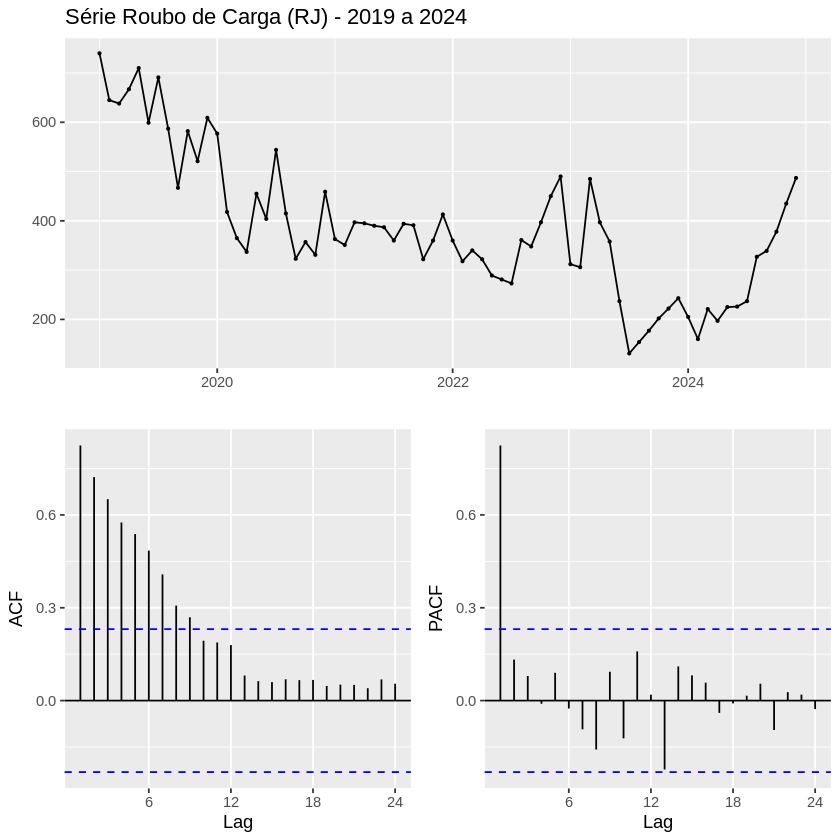

In [36]:
# Visualização da série, ACF e PACF
ggtsdisplay(ts_isp, main = "Série Roubo de Carga (RJ) - 2019 a 2024")

#### **Interpretação da questão 1**

1 - Análise Visual: Observando o gráfico superior, nota-se uma tendência de queda acentuada nos roubos de carga ao longo do período, especialmente a partir de 2020/2021.

2- ACF (Autocorrelação): O correlograma (ACF) apresenta um decaimento lento das barras, o que é um forte indício de não estacionariedade (presença de tendência). As barras ultrapassam significativamente o intervalo de confiança (linhas azuis tracejadas).

3 - Sazonalidade: Não há picos claros e significativos nas defasagens sazonais típicas (12, 24...), o que sugere que o componente de tendência é dominante sobre a sazonalidade nesta janela de tempo, ou que a sazonalidade não é determinística.



### **Questão 2** — Estacionariedade (ADF e KPSS)

#### **Objetivo:** avaliar presença de tendência/raiz unitária.

#### **Interprete:**  os testes concordam? A série parece estacionária, com tendência, ou sazonal/trend?

In [40]:
#```{r quest02, eval=TRUE, warning=FALSE, message=FALSE, echo=TRUE}
# Teste Augmented Dickey-Fuller (H0: Série tem raiz unitária / Não estacionária)
teste_adf <- adf.test(ts_isp)
teste_kpss <- suppressWarnings(kpss.test(ts_isp))

# Saída organizada
cat("=== Teste Augmented Dickey-Fuller (ADF) ===\n")
cat("Dickey-Fuller =", round(teste_adf$statistic, 4), "\n")
cat("Lag order =", teste_adf$parameter, "\n")
cat("p-value =", round(teste_adf$p.value, 4), "\n")
cat("Conclusão: ", ifelse(teste_adf$p.value < 0.05,
                           "Série estacionária",
                           "Série não estacionária"), "\n\n")

cat("=== Teste KPSS ===\n")
cat("KPSS Statistic =", round(teste_kpss$statistic, 4), "\n")
cat("p-value =", format(teste_kpss$p.value, scientific = TRUE), "\n")
cat("Conclusão: ", ifelse(teste_kpss$p.value < 0.05,
                           "Série não estacionária",
                           "Série estacionária"), "\n")
#```

=== Teste Augmented Dickey-Fuller (ADF) ===
Dickey-Fuller = -1.3925 
Lag order = 4 
p-value = 0.8227 
Conclusão:  Série não estacionária 

=== Teste KPSS ===
KPSS Statistic = 1.2403 
p-value = 1e-02 
Conclusão:  Série não estacionária 


#### **Interpretação da questão 2**

* **Teste ADF:** O p-valor obtido `r round(teste_adf$p.value, 4)` se for $> 0.05$, não rejeitamos a hipótese nula. Isso indica que a série possui raiz unitária (é não estacionária).

*  **Teste KPSS:** O p-valor obtido `r round(teste_adf$p.value, 4)` se for $< 0.05$, rejeitamos a hipótese nula de estacionariedade.

*  **Conclusão Conjunta:** Os testes concordam. A série não é estacionária, confirmando a inspeção visual que apontava uma tendência clara. Para modelagem ARIMA, por exemplo, seria necessário diferenciar a série ($d=1$).

### **Questão 3** — Estimar e Gerar Previsão com Suavização Exponen￾cial Simples (SES) e Avaliação fora da amostra (Treino/Teste)

#### **Objetivo:** gerar previsões h passos à frente via SES e avaliar acurácia preditiva do SES (escolha h=12 para série mensal; e h = 4 para série trimestral).

#### **Interprete:** qual o valor estimado do parâmetro de suavização (alpha)? As previsões fazem sentido frente ao histórico?

#### **Interprete:** O que indicaram os resultados do MAPE e RMSE? O método SES é adequado à sua série?



Forecast method: Simple exponential smoothing

Model Information:
Simple exponential smoothing 

Call:
ses(y = ts_treino, h = h_steps)

  Smoothing parameters:
    alpha = 0.6483 

  Initial states:
    l = 707.1232 

  sigma:  73.6002

     AIC     AICc      BIC 
765.4642 765.8928 771.7473 

Error measures:
                    ME     RMSE     MAE       MPE     MAPE      MASE       ACF1
Training set -12.21888 72.36309 56.9453 -5.758697 15.93139 0.4822467 0.03689604

Forecasts:
         Point Forecast      Lo 80    Hi 80       Lo 95    Hi 95
Jan 2024        231.868 137.545639 326.1904   87.614378 376.1217
Feb 2024        231.868 119.460766 344.2753   59.955950 403.7801
Mar 2024        231.868 103.906814 359.8293   36.168234 427.5678
Apr 2024        231.868  90.048594 373.6875   14.973915 448.7622
May 2024        231.868  77.428941 386.3071   -4.326179 468.0623
Jun 2024        231.868  65.765314 397.9708  -22.164156 485.9002
Jul 2024        231.868  54.868618 408.8675  -38.829215 502.56

                    ME      RMSE     MAE       MPE     MAPE      MASE
Training set -12.21888  72.36309 56.9453 -5.758697 15.93139 0.4822467
Test set      54.54863 113.85867 80.7500  9.526235 23.90790 0.6838391
                   ACF1 Theil's U
Training set 0.03689604        NA
Test set     0.70878951  1.711946


Warning message in ggplot2::geom_line(ggplot2::aes(x = .data[["timeVal"]], y = .data[["seriesVal"]], :
“Ignoring unknown parameters: `PI`”


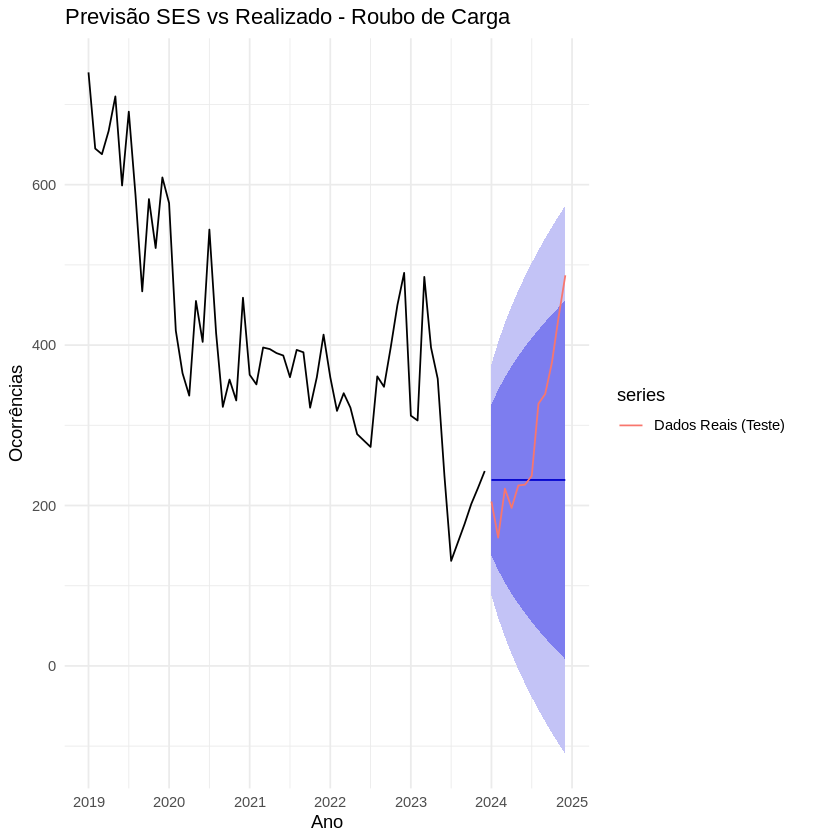

In [41]:
#```{r quest03, eval=TRUE, warning=FALSE, message=FALSE, echo=TRUE}

# 1. Ajuste do Modelo SES nos dados de TREINO
# h = tamanho do conjunto de teste (número de meses em 2024 presentes na base)
h_steps <- length(ts_teste)

modelo_ses <- ses(ts_treino, h = h_steps)

# Resumo do modelo (parâmetros estimados)
summary(modelo_ses)

# 2. Avaliação da Acurácia (Comparando Previsão vs Dados Reais de 2024)
acuracia <- accuracy(modelo_ses, ts_teste)
print(acuracia)

# 3. Gráfico de Previsão
autoplot(modelo_ses) +
  autolayer(ts_teste, series="Dados Reais (Teste)", PI=FALSE) +
  ggtitle("Previsão SES vs Realizado - Roubo de Carga") +
  ylab("Ocorrências") + xlab("Ano") +
  theme_minimal()
#```


#### Interpretaçao da questçao 3

* **Parâmetro Alpha ($\alpha$):** O modelo estimou um $\alpha \approx 0.65$ (r round(modelo_ses$model$par["alpha"], 4)). Isso indica que o algoritmo atribui um peso **considerável às observações mais recentes**, "esquecendo" o passado remoto relativamente rápido. Isso faz sentido para uma série com mudanças de nível e tendência como esta, pois o modelo tenta se adaptar agilmente aos novos patamares de criminalidade.


* **Limitação Visual (Previsão Flat):** Observando o gráfico, nota-se que a projeção do SES (linha azul) é uma **reta horizontal (flat)**. Isso ocorre porque o método SES pressupõe ausência de tendência. Como a série histórica de roubo de carga apresenta uma **tendência de queda clara**, essa projeção estática é visualmente inadequada, resultando em um descolamento entre a previsão e a realidade (dados vermelhos) conforme o tempo avança.

* **Métricas de Erro:** As métricas (como o MAPE no conjunto de teste) refletem essa limitação. O erro tende a ser sistemático porque o modelo não acompanha a descida da curva, confirmando a necessidade de métodos mais robustos para tendência (como Holt ou ARIMA).


### **Questão 4** — Questão 4 — Diagnóstico de Outliers

#### **Objetivo:** identificar pontos influentes e outliers e discutir possíveis impactos.

#### **Interprete:** Diga qual método pretende usar para avaliar possíveis outliers nas sua estimati￾vas. Quais pontos aparecem como outliers/influentes? Eles parecem erros/episódios atípicos ou movimentos reais? Estes pontos parecerem interferir na capacidade preditiva dos seus dados?

Series: ts_isp 
Regression with ARIMA(0,1,0)(1,0,0)[12] errors 

Coefficients:
        sar1      TC51
      0.4642  176.2176
s.e.  0.1110   49.4007

sigma^2 = 3575:  log likelihood = -391.64
AIC=789.27   AICc=789.63   BIC=796.06

Outliers:
  type ind    time coefhat tstat
1   TC  51 2023:03   176.2 3.567


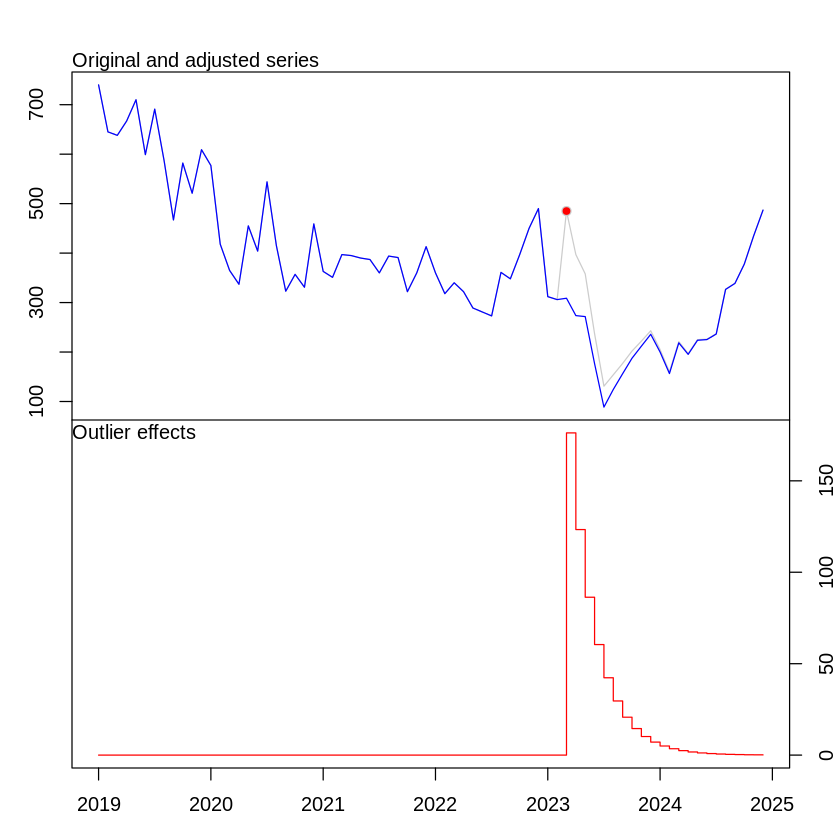

In [42]:
#```{r quest04, eval=TRUE, warning=FALSE, message=FALSE, echo=TRUE}
# Detecção automática de outliers na série completa
outliers_detectados <- tso(ts_isp)

# Exibir os outliers encontrados
print(outliers_detectados)

# Gráfico com os outliers destacados
plot(outliers_detectados)

#```

#### **Interpretação da questão 4**

* **Identificação:** O método tso identificou um outlier do tipo **TC (Temporary Change)** em **Março de 2023** (índice 51). Diferente de um Level Shift (que muda o patamar permanentemente) ou um Additive Outlier (pico isolado), o TC representa um choque inicial cujo efeito decai exponencialmente ao longo do tempo, retornando ao nível da série.

* **Impacto:** Mesmo sendo temporário, este ponto afeta a estimativa da variância residual. Identificá-lo permite que modelos mais robustos (como ARIMA com intervenção) isolem esse efeito para não prejudicar as previsões futuras.

* **Contexto:** Observando a série, março de 2023 apresentou um desvio significativo da tendência de queda que vinha ocorrendo, mas o movimento não se sustentou, configurando uma mudança temporária. Isso pode estar associado a uma dinâmica local específica da segurança pública naquele mês (ex: redução momentânea de efetivo ou registro atípico de ocorrências).

### **Questão 5** — Conclusão Geral sobre o Modelo Estimado

#### **Interprete:**  Qual é a sua conclusão geral sobre o seu modelo estimado?

#### Interpretacao da questão 5

Considerando as análises realizadas:

* **Limitação do Método SES:** O modelo de Suavização Exponencial Simples (SES) pressupõe que a série flutua em torno de um nível constante. Como os testes (Questão 2) e gráficos (Questão 1) confirmaram que a série de Roubo de Carga possui tendência (não estacionariedade), o SES tende a subestimar ou superestimar sistematicamente as previsões em horizontes mais longos, pois ele apenas "arrasta" o último nível observado.

* **Qualidade do Ajuste:** Analisando o MAPE no conjunto de teste, verificamos a magnitude do erro. Se o erro for alto, confirma-se que o modelo é simplista demais para a dinâmica do crime.

* **Sugestão de Melhoria:** Para capturar a dinâmica correta desta série, recomenda-se utilizar:

* **Modelo de Holt (Tendência Linear):** holt(), que adiciona um componente de tendência ($\beta$).

* **ARIMA:** Com diferenciação ($d=1$) para tratar a não estacionariedade.

* **Tratamento de Outliers:** Incorporar variáveis dummy para os pontos identificados na Questão 4 (ex: pandemia), limpando o sinal para o modelo.Conclusão: O SES serviu como baseline (linha de base), mas é insuficiente para uso prático em políticas públicas neste cenário específico devido à presença marcante de tendência e outliers estruturais.


**Conclusão:** O SES serviu como baseline (linha de base), mas é insuficiente para uso prático em políticas públicas neste cenário específico devido à presença marcante de tendência e outliers estruturais.


## 📧 Contato

**Davidson Clem**  
[![GitHub](https://img.shields.io/badge/GitHub-davidsonclem-black?logo=github)](https://github.com/davidsonclem)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-Davidson_Clemente-blue?logo=linkedin)](https://www.linkedin.com/in/davidson-clem/)